# Import Torch and enable gpu

In [62]:
import torch 
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [63]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision

In [64]:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

In [65]:
image_path = "./data/capsule/train/good/000.png"
image = Image.open(image_path)
print(image.size)

(1000, 1000)


In [66]:
transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image = transforms(image)

torch.Size([3, 224, 224])


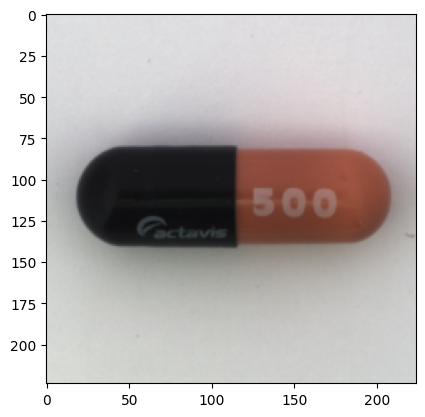

In [67]:
print(image.shape)
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.show()

# Memory

In [68]:
memory_usage = image.numel() * image.element_size()
print(f"Memory usage: {memory_usage / (1024 ** 2):.2f} MB")
print(f'Memory for all 208 images: {memory_usage * 208 / (1024 ** 2):.2f} MB')

Memory usage: 0.57 MB
Memory for all 208 images: 119.44 MB


In [69]:
train_image_folder = ImageFolder(root="./data/capsule/train", transform=transforms)
x, y = train_image_folder[0]
print(f"Image shape: {x.shape}, Label: {y}")

Image shape: torch.Size([3, 224, 224]), Label: 0


In [70]:
train_dataset,val_dataset = torch.utils.data.random_split(train_image_folder, [0.8, 0.2])
print(f"Train dataset size: {len(train_dataset)}")

Train dataset size: 176


# Dataloading


In [71]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

image_batch, labels = next(iter(train_loader))
print(f"Batch image shape: {image_batch.shape}, Batch labels shape: {labels.shape}")

memory_usage_batch = image_batch.numel() * image_batch.element_size()
print(f"Memory usage for batch: {memory_usage_batch / (1024 ** 2):.2f} MB")

Batch image shape: torch.Size([16, 3, 224, 224]), Batch labels shape: torch.Size([16])
Memory usage for batch: 9.19 MB


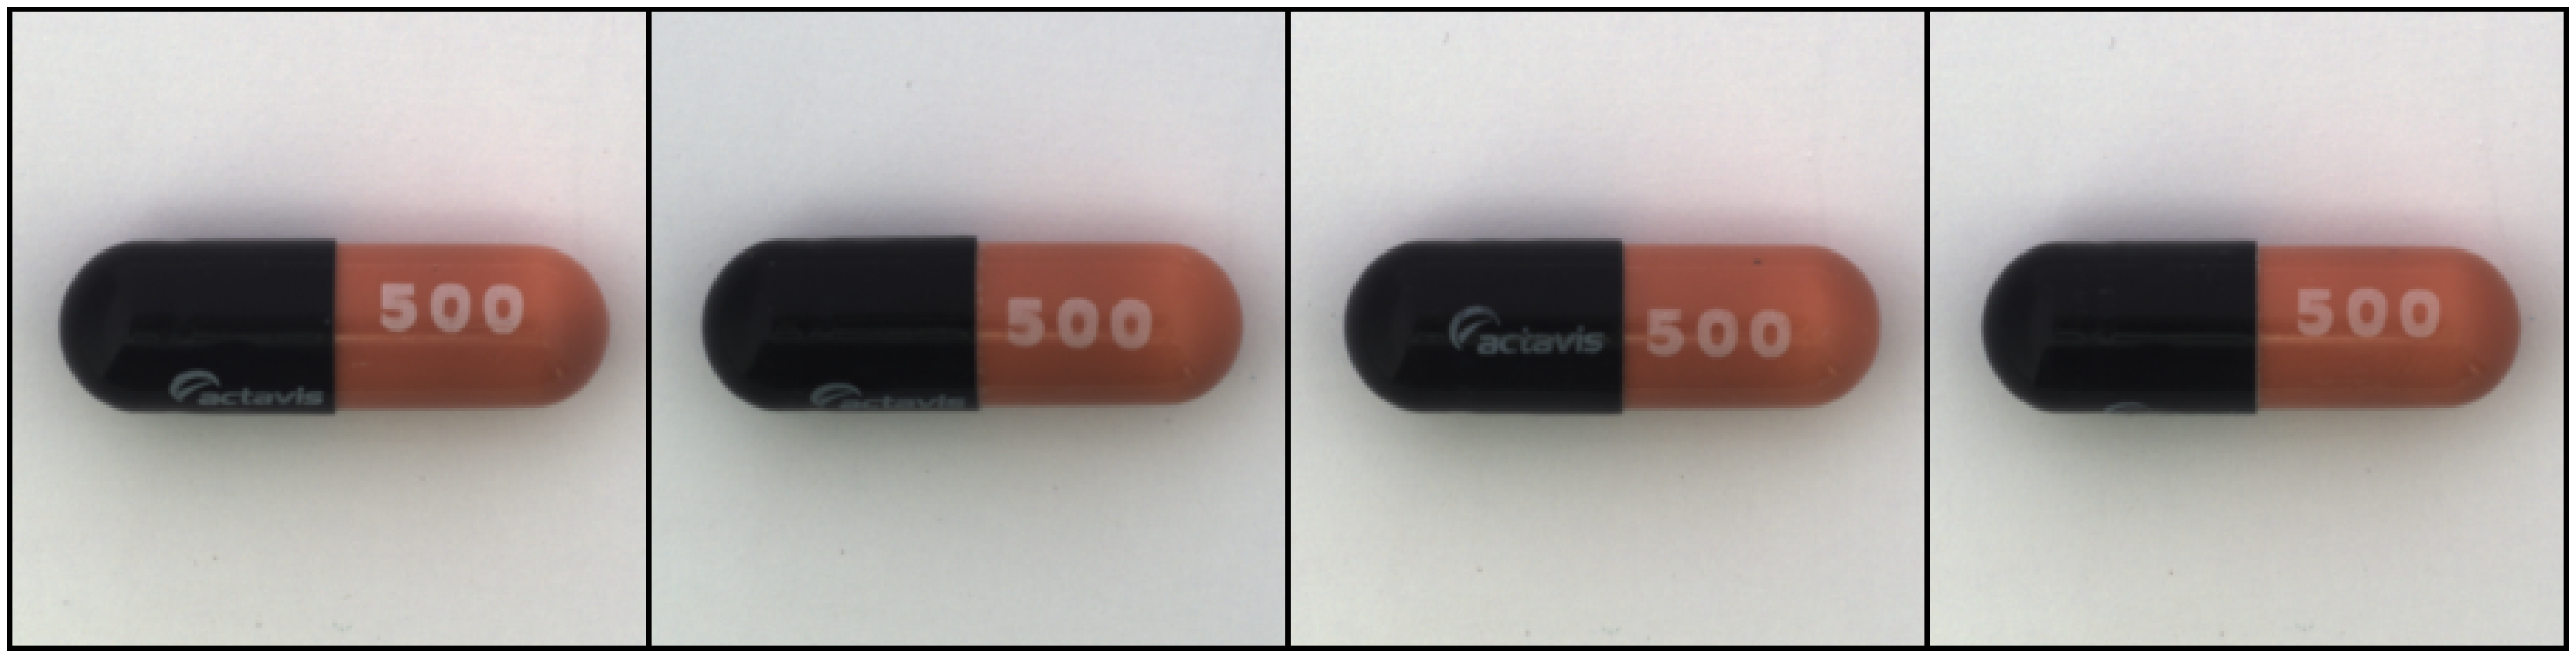

In [72]:
plt.figure(figsize=(12*4, 8*4))
grid_size = torchvision.utils.make_grid(image_batch[0:4], nrow=4)
plt.imshow(np.transpose(grid_size.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [73]:
input_image = Image.open(r'.\data\capsule\train\good\000.png')
input_image = transforms(input_image) 

input_image = input_image.unsqueeze(0) 

c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)

torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim: int = 128):
        super().__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        feat_dim = 256 * 25 * 25
        self.fc_mu = nn.Linear(feat_dim, latent_dim)
        self.fc_logvar = nn.Linear(feat_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, feat_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder_conv(x)
        h_flat = self.flatten(h)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        z = self.reparameterize(mu, logvar)
        dec = self.fc_decode(z).view(-1, 256, 25, 25)
        recon = self.decoder(dec)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta: float = 1.0, recon_type: str = 'mse'):
    if recon_type == 'l1':
        recon_loss = F.l1_loss(recon_x, x, reduction='sum')
    else:
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl, recon_loss, kl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
input_image = torch.randn(1, 3, 224, 224, device=device)
with torch.no_grad():
    output_image, mu, logvar = model(input_image)
print(output_image.shape)

torch.Size([1, 3, 224, 224])


In [75]:
import os
os.makedirs('models', exist_ok=True)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  2%|▏         | 1/50 [00:08<07:04,  8.66s/it]

Epoch 1/50 beta=0.10 train=221501.09 val=198771.89


 12%|█▏        | 6/50 [00:53<06:34,  8.96s/it]

Epoch 6/50 beta=0.60 train=22027.84 val=17919.83


 22%|██▏       | 11/50 [01:38<05:45,  8.85s/it]

Epoch 11/50 beta=1.00 train=9831.57 val=8374.21


 32%|███▏      | 16/50 [02:22<05:02,  8.90s/it]

Epoch 16/50 beta=1.00 train=7444.65 val=6366.96


 42%|████▏     | 21/50 [03:07<04:22,  9.04s/it]

Epoch 21/50 beta=1.00 train=6146.84 val=5244.23


 52%|█████▏    | 26/50 [03:49<03:24,  8.52s/it]

Epoch 26/50 beta=1.00 train=5802.21 val=5114.39


 62%|██████▏   | 31/50 [04:31<02:41,  8.52s/it]

Epoch 31/50 beta=1.00 train=4965.45 val=4418.46


 72%|███████▏  | 36/50 [05:13<01:56,  8.29s/it]

Epoch 36/50 beta=1.00 train=4938.25 val=4355.98


 82%|████████▏ | 41/50 [05:55<01:14,  8.25s/it]

Epoch 41/50 beta=1.00 train=4668.80 val=4242.46


 92%|█████████▏| 46/50 [06:36<00:33,  8.32s/it]

Epoch 46/50 beta=1.00 train=4449.67 val=4002.33


100%|██████████| 50/50 [07:11<00:00,  8.63s/it]



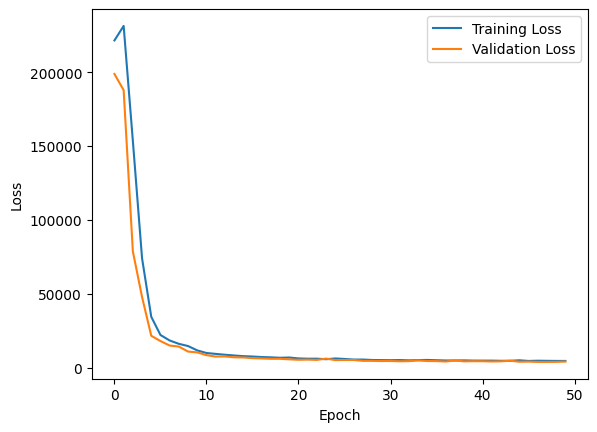

In [76]:
from tqdm import tqdm
Loss = []
Val_Loss = []

num_epochs = 50
warmup_epochs = 10
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

best_val = float('inf')

for epoch in tqdm(range(num_epochs)):
    model.train()
    beta = min(1.0, (epoch + 1) / warmup_epochs)
    epoch_loss = 0.0
    batches = 0
    for img, _ in train_loader:
        img = img.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            recon, mu, logvar = model(img)
            loss, rec_l, kl_l = vae_loss(recon, img, mu, logvar, beta=beta, recon_type='mse')
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        batches += 1
    Loss.append(epoch_loss / max(1, batches))

    model.eval()
    val_sum = 0.0
    val_batches = 0
    with torch.no_grad():
        for img, _ in val_loader:
            img = img.to(device)
            recon, mu, logvar = model(img)
            loss, _, _ = vae_loss(recon, img, mu, logvar, beta=1.0)
            val_sum += loss.item()
            val_batches += 1
    val_avg = val_sum / max(1, val_batches)
    Val_Loss.append(val_avg)

    if val_avg < best_val:
        best_val = val_avg
        torch.save(model.state_dict(), 'models/vae_capsule_best.pt')

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} beta={beta:.2f} train={Loss[-1]:.2f} val={Val_Loss[-1]:.2f}")

plt.plot(Loss, label='Training Loss')
plt.plot(Val_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
# Save latest and reload best
torch.save(model.state_dict(), 'models/vae_latest.pt')
model.eval()

# Optionally reload best
try:
    ckpt = torch.load('models/vae_capsule_best.pt', map_location=device)
    model.load_state_dict(ckpt)
    print('Loaded best checkpoint')
except Exception as e:
    print('No best checkpoint yet:', e)

Loaded best checkpoint


torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

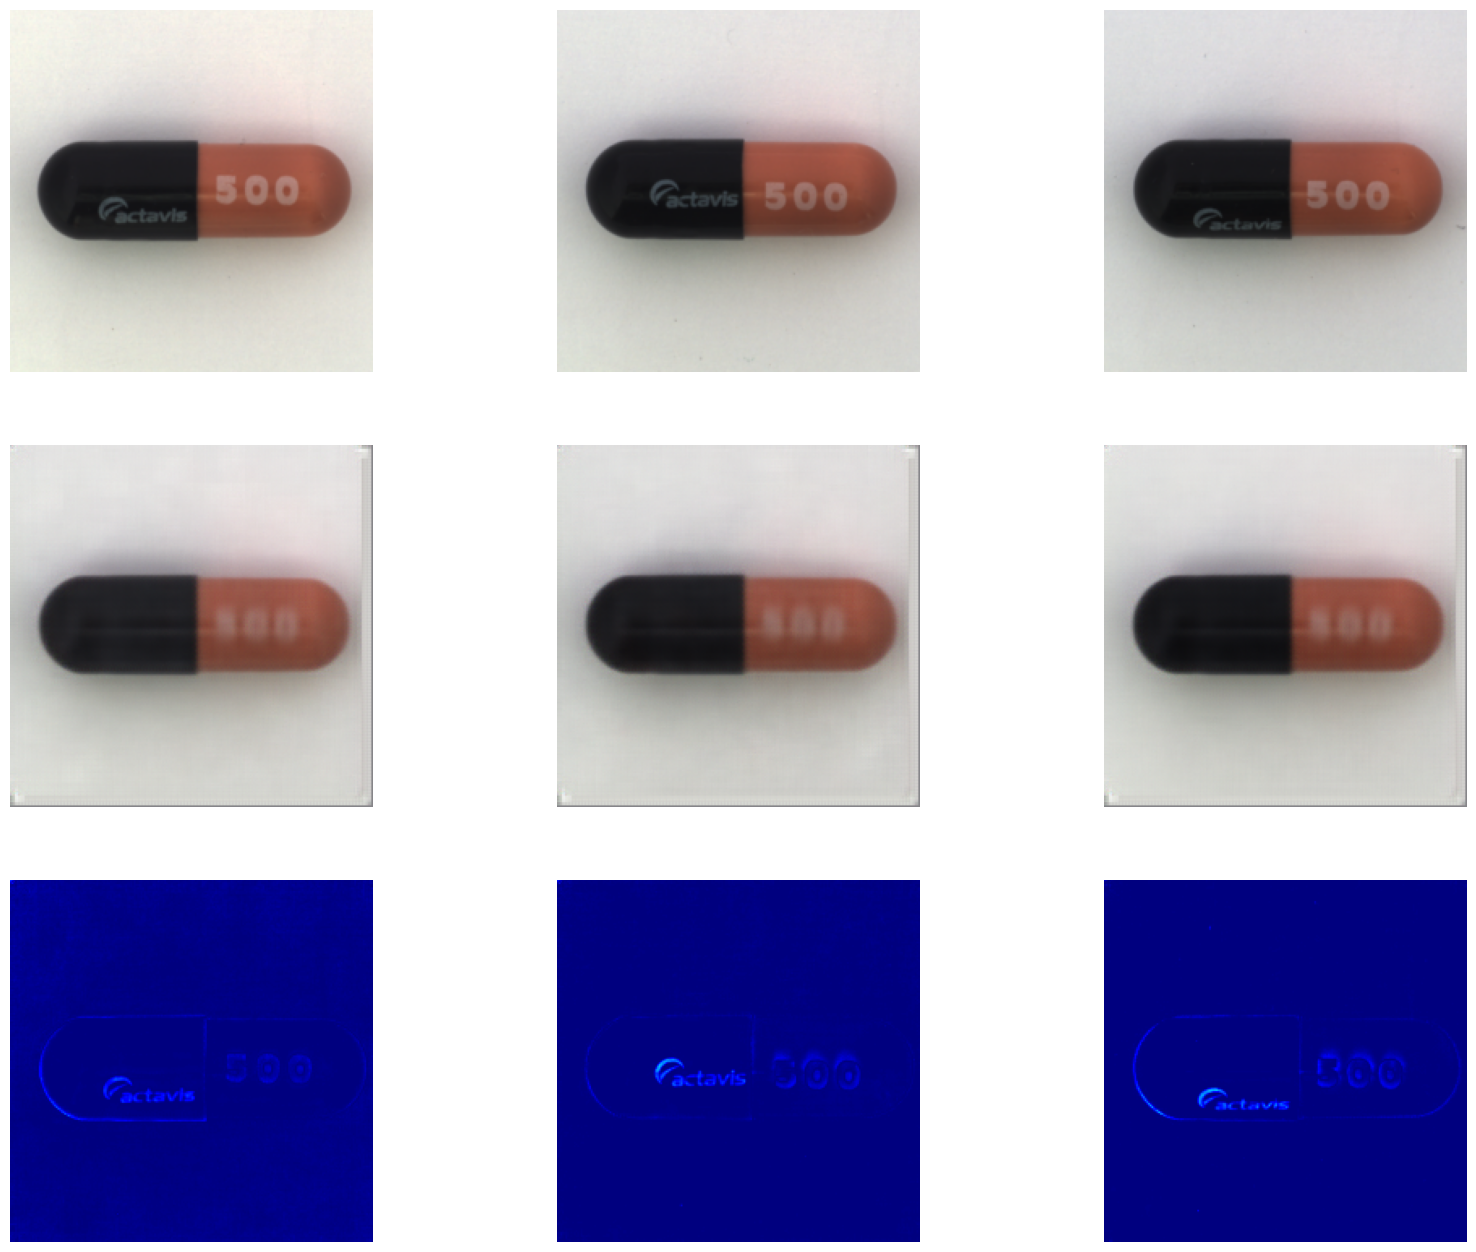

In [78]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.to(device)
        recon, mu, logvar = model(data)
        break

recon_error = ((data - recon) ** 2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10, 0:-10].cpu().numpy(), cmap='jet', vmax=torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

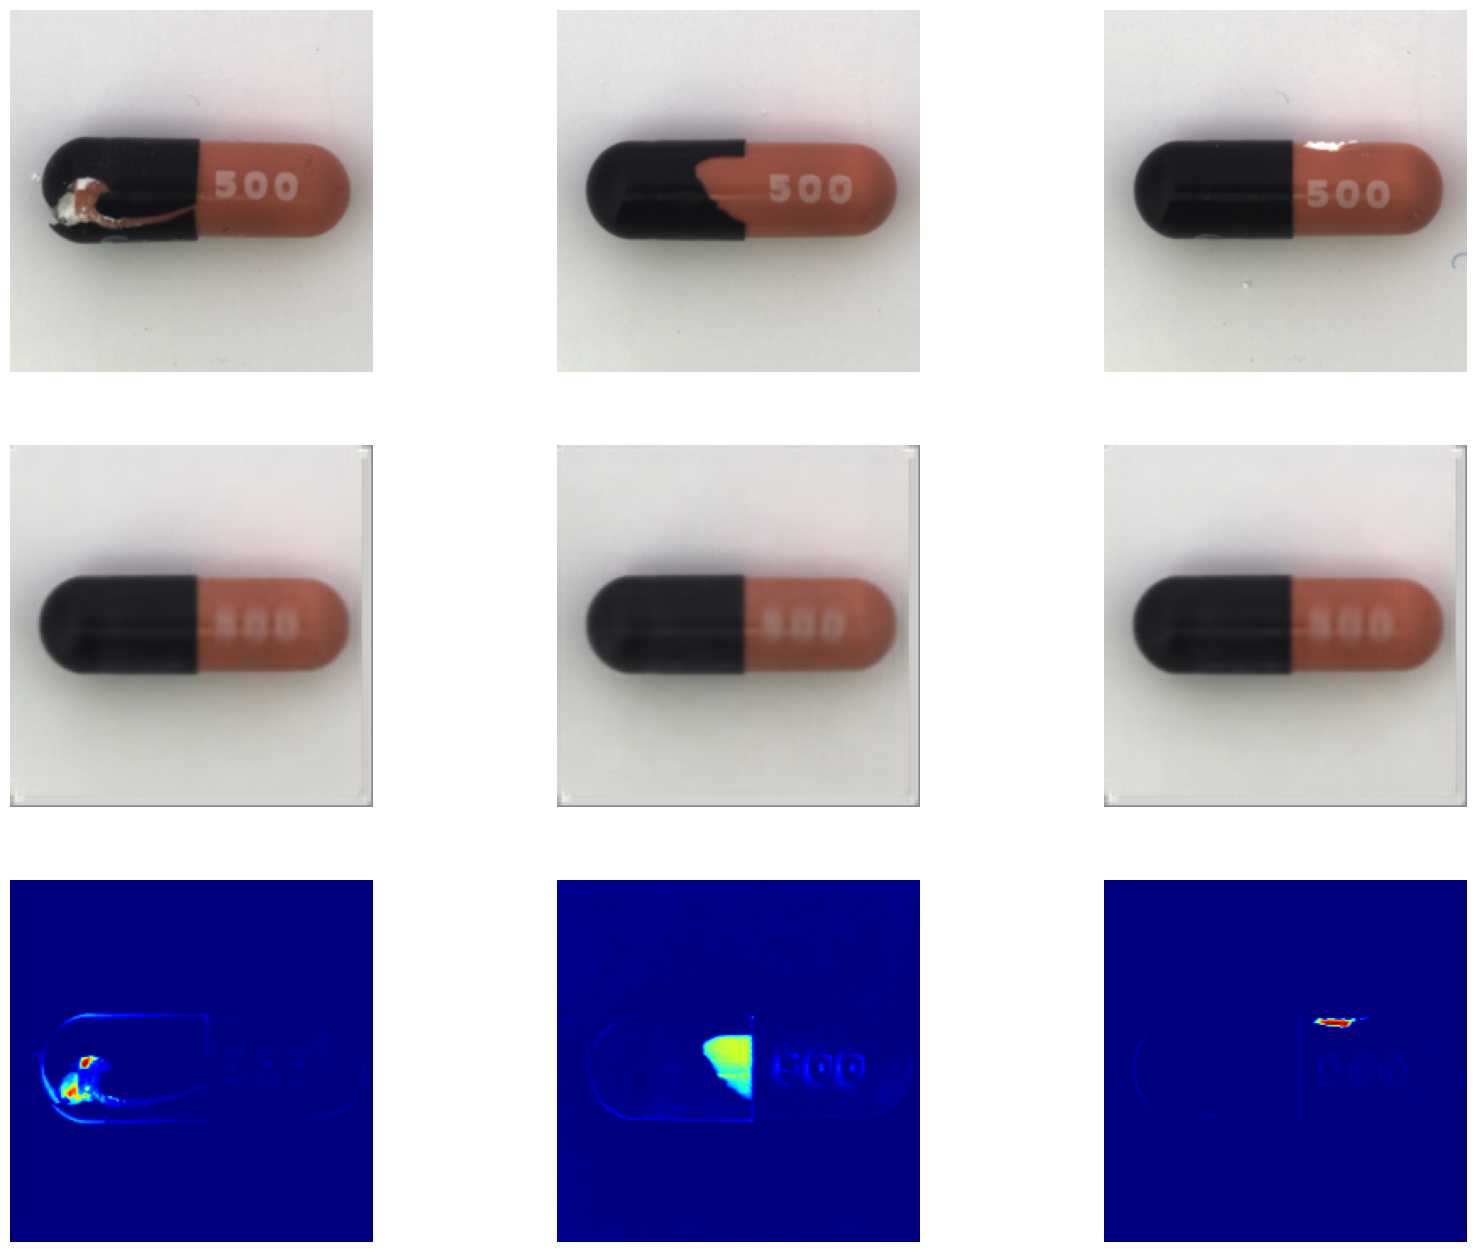

In [81]:
test_image_1 = transforms(Image.open(r'data\\capsule\\test\\crack\\001.png'))
test_image_2 = transforms(Image.open(r'data\\capsule\\test\\crack\\010.png'))
test_image_3 = transforms(Image.open(r'data\\capsule\\test\\crack\\004.png'))

data = torch.stack([test_image_1, test_image_2, test_image_3])

with torch.no_grad():
    data = data.to(device)
    recon, mu, logvar = model(data)

recon_error = ((data - recon) ** 2).mean(axis=1)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10, 0:-10].cpu().numpy(), cmap='jet', vmax=torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

In [80]:
with torch.no_grad():
    sample, _ = next(iter(train_loader))
image = sample[0].cpu()
memory_usage = image.numel() * image.element_size()
print(f"Memory usage: {memory_usage / (1024 ** 2):.2f} MB")
print(f"Memory for all 208 images: {memory_usage * 208 / (1024 ** 2):.2f} MB")
try:
    n_train = len(train_dataset)
    print(f"Train set ({n_train} images): {memory_usage * n_train / (1024 ** 2):.2f} MB")
except Exception:
    pass

Memory usage: 0.57 MB
Memory for all 208 images: 119.44 MB
Train set (176 images): 101.06 MB
